Feature Selection for Classification of After-Effect Success
---
In this notebook, single, two-way, and three-way interactions of features useful for classifying After-Effect success are identified.

** After-Effects **

After-Effects indicate the amount that subjects gait was recalibrated by the split-belt gait training. In other words, the After-Effects indicate how much an individual's gait changed due to gait training. So a non-zero After-Effects means that the gait changed, where values close to zero indicate minimal changes in gait due to training.  If gait retraining was successful, the gait following training should look different than it did before gait training (non-zero After-Effects).  Although After-Effects are continuous, here we are classifying those whose gait training was successful (i.e., gait changed due to training) versus those whose gait training was not successful (i.e., no change in gait due to training).

**Feature Selection Methods**

*Random Forest:*  A Random Forest will be used to identify important features.

*Gradient Boosting:*  Gradient Boosting was utilized in order to calculate Friedman and Popescu’s H statistics to indentify important 2-way and 3-way interactions.

** Selected Features**

Single Features:
- Mid Speed
- AdaptationDuration
- SpeedDifference

Two-Way Feature Interactions:
- ('MidSpeed', 'AdaptationDuration'): 0.413889214826596,
- ('SpeedDifference', 'C(IsCatch)[T.1]'): 0.3513170447225953

Three-Way Feature Interactions:
- None

Reference Material:
- https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76
- https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
- https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Random%20Forest%20Explained.ipynb
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Import Data
---

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

df = pd.read_csv("CleanDataBase.csv")
df.head()

,Lab,ID,GroupNum,Height,Weight,Age,Male,RightLeg_Dom,RightLeg_Fast,AdaptationDurationMins,...,Stroke,TextSpeedRatio,EventDetection,DomFast,BMI,Young,TMSteadyGood,TMAfterGood,DeltaAda,DeltaAdaGood
0,SML,B001,1.0,160.0,60.9,20.0,0,1,1,NaN,...,0,2.0,NaN,1,23.789062,1,1,1,0.291812,1
1,SML,B003,1.0,174.0,68.0,20.0,0,1,1,NaN,...,0,2.0,NaN,1,22.460034,1,1,1,0.220894,1
2,SML,B004,1.0,159.0,59.2,20.0,1,1,1,NaN,...,0,2.0,NaN,1,23.416795,1,0,1,0.198431,1
3,SML,BC001,1.0,160.0,60.9,20.0,0,1,1,NaN,...,0,2.0,NaN,1,23.789062,1,1,1,0.220999,1
4,SML,BC004,1.0,165.0,65.0,20.0,1,1,1,NaN,...,0,2.0,NaN,1,23.875115,1,0,1,0.355004,1


In [2]:
df.shape

(536, 38)

In [3]:
# set random seed to increase repeatability
import numpy as np
RSEED=50
np.random.seed(RSEED)

Potential Features and Targets
---

In [4]:
from patsy import dmatrices

Y, X = dmatrices('TMAfterGood ~ C(SpeedRatio) + SpeedDifference + MidSpeed+ C(Abrupt) + TMBase + \
               AdaptationDuration + Age + C(Young) + Height + Weight + BMI + C(IsCatch) + C(Stroke)', df, return_type="dataframe")

feature_cols = ['C(SpeedRatio)[T.3.0]', 'SpeedDifference', 'MidSpeed', 'C(Abrupt)[T.1]', 'TMBase', \
               'AdaptationDuration', 'Age', 'C(Young)[T.1]', 'Height', 'Weight', 'BMI', 'C(IsCatch)[T.1]', 'C(Stroke)[T.1]']

target_cols = ["TMAfterGood"]

df_Interactions = pd.concat([X,Y], axis=1)

Features = df_Interactions[feature_cols]
Target = df_Interactions[target_cols]

Split the Data into Training and Testing Sets
---

In [5]:
# Split data into training and testing set
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(Features,Target,test_size=0.2, random_state = RSEED)

y_test=y_test.values.ravel()
y_train=y_train.values.ravel()

Up Sampling
---


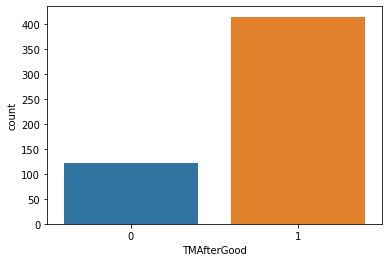

In [6]:
import seaborn as sns # Also to visualize
sns.countplot(x = "TMAfterGood", data = df)
plt.show()

In [7]:
# From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=feature_cols)
os_data_y = pd.DataFrame(data=os_data_y,columns=target_cols)

In [8]:
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of BadAE in oversampled data",len(os_data_y[os_data_y["TMAfterGood"]==0]))
print("Number of GoodAE",len(os_data_y[os_data_y[target_cols]==1]))
print("Proportion of BadAE data in oversampled data is ",len(os_data_y[os_data_y["TMAfterGood"]==0])/len(os_data_X))
print("Proportion of GoodAE in oversampled data is ",len(os_data_y[os_data_y["TMAfterGood"]==1])/len(os_data_X))

length of oversampled data is  658
Number of BadAE in oversampled data 329
Number of GoodAE 658
Proportion of BadAE data in oversampled data is  0.5
Proportion of GoodAE in oversampled data is  0.5


In [9]:
X_train = os_data_X
y_train = os_data_y

Random Forest
---

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(random_state=RSEED, max_depth=4)
# Fit on training data
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

Saving and Visualizing the Un-Optimized Forest
---

In [11]:
from sklearn.tree import export_graphviz
import pydot
import matplotlib.image as mpimg

def SaveAndVisualizeForest(model, figName, FeatureNames):
    estimator = model.estimators_[1]

    export_graphviz(estimator, out_file = figName + '.dot', feature_names = FeatureNames,
                rounded = True, precision = 1, class_names = ['goodAE', 'badAE'], filled = True)


    # Use dot file to create a graph
    (graphy, ) = pydot.graph_from_dot_file(figName + '.dot')

    # Write graph to a png file
    graphy.write_png(figName + '.png'); 
    
    #Visualize for notebook
    img = mpimg.imread(figName + '.png')
    fig = plt.figure()
    fig.set_size_inches(30,10)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

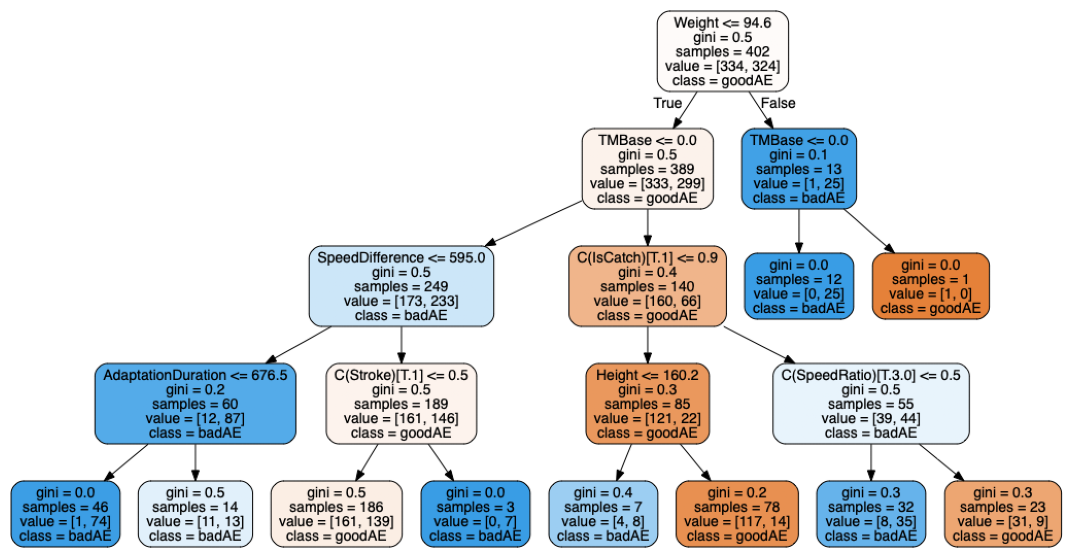

In [12]:
SaveAndVisualizeForest(model, 'AEForest', feature_cols)

Make Predictions
---

In [13]:
# Actual class predictions
rf_predictions = model.predict(X_test)

# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]


Random Forest Evaluation: Confusion Matrix
---

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt  # To visualize

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

Confusion matrix, without normalization


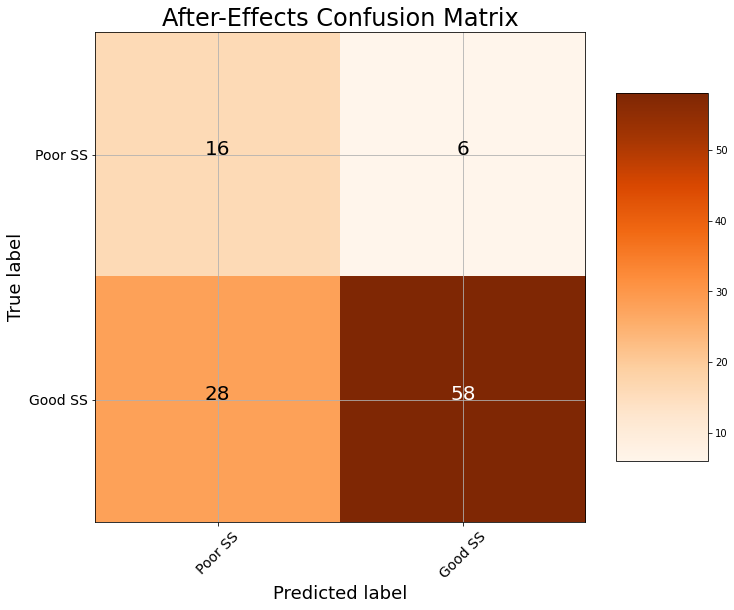

In [15]:
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor SS', 'Good SS'],
                      title = 'After-Effects Confusion Matrix')

Random Forest Evaluation:  ROC & Precision/Recall Curves
---

In [16]:
## Tagen from: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs, train_labels, test_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

Recall Baseline: 1.0 Test: 0.67 Train: 0.81
Precision Baseline: 0.8 Test: 0.91 Train: 0.96
Roc Baseline: 0.5 Test: 0.81 Train: 0.97


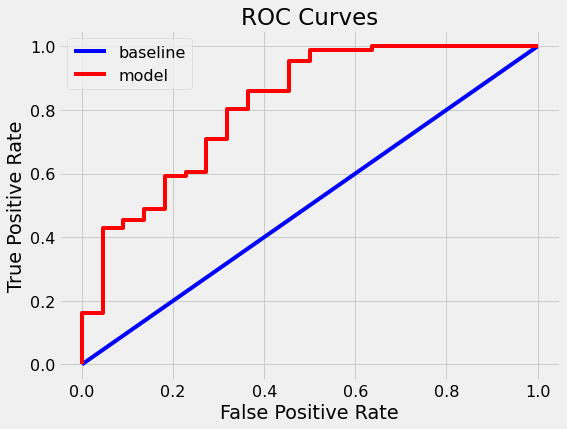

In [17]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, y_train, y_test)

Feature Selection: Single Features
---

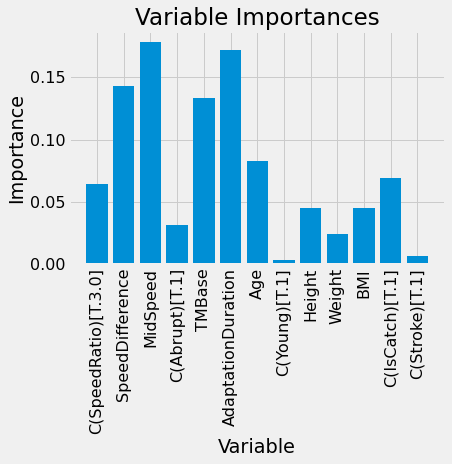

In [18]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train),
                   'importance_unop': model.feature_importances_})

# Make a bar chart
plt.bar(fi.feature, fi.importance_unop, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(fi.feature, list(X_train), rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

Three most most important single features are:
- Mid Speed
- AdaptationDuration
- SpeedDifference

Feature Selection: Interactions Identified with Friedman and Popescu’s H statistics
---

In order to compute the H statistic I must use a Boosting Classifier, I will be using Gradient Boosting Classifier.  I will be accessing 2-way and 3-way interactions seperately.

References:
- https://christophm.github.io/interpretable-ml-book/interaction.html#implementations <br />
- https://pypi.org/project/sklearn-gbmi/  <br />
- https://github.com/ralphhaygood/sklearn-gbmi/blob/master/example.ipynb <br />
- https://blog.macuyiko.com/post/2019/discovering-interaction-effects-in-ensemble-models.html <br />

In [19]:
from sklearn_gbmi import *
from sklearn.ensemble import GradientBoostingRegressor

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

gbr_1 = GradientBoostingRegressor()
gbr_1.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 2-Way Interactions

In [20]:
# Compute the two-variable H statistic of each pair of predictor variables. 
TwoWay_HStat = h_all_pairs(gbr_1, X_train)

{k: v for k, v in TwoWay_HStat.items() if v >= 0.35}

{('MidSpeed', 'AdaptationDuration'): 0.413889214826596,
 ('SpeedDifference', 'C(IsCatch)[T.1]'): 0.3513170447225953}

**Most Significant 2-way Interactions (>0.35):**
- ('MidSpeed', 'AdaptationDuration'): 0.413889214826596
- ('SpeedDifference', 'C(IsCatch)[T.1]'): 0.3513170447225953

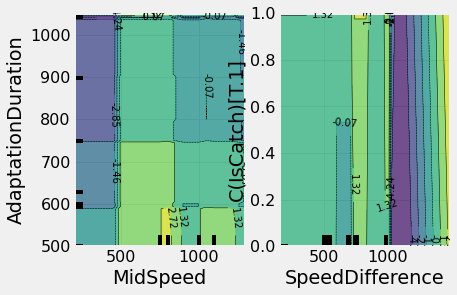

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(Features, Target.values.ravel())

features = [(2, 5), (1, 11)]# (4, 10), (10, 11)
plot_partial_dependence(clf, Features, features) 
plt.show()

Recall that the "IsCatch" indicates wether the After-Effects were measured during a short 10 stride (i.e. a step with each foot) or an extended walking trail.  It is unclear why this would influence the After-Effects.  More data is needed to verify this interaction.

### 3-Way Interactions

In [22]:
from itertools import combinations

FeatureName = list(X_train)
Combos = list(combinations(range(len(FeatureName)),3))

for x in range(len(Combos)):#len(Combos):
    ThreeNames = [FeatureName[Combos[x][0]], FeatureName[Combos[x][1]], FeatureName[Combos[x][2]]]
    ThreeFeatures = X_train[ThreeNames]
    
    gbr_2 = GradientBoostingRegressor()        
    gbr_2.fit(ThreeFeatures, y_train.values.ravel())
    ThreeInteraction = h(gbr_2, ThreeFeatures)
    if ThreeInteraction>0.25:
        print(ThreeNames, ' --> ', ThreeInteraction )

Selected Features to Predict Binary After-Effect Outcome
---

Single Features:
- Mid Speed
- AdaptationDuration
- SpeedDifference

Two-Way Feature Interactions:
- ('MidSpeed', 'AdaptationDuration'): 0.413889214826596,
- ('SpeedDifference', 'C(IsCatch)[T.1]'): 0.3513170447225953

Three-Way Feature Interactions:
- None

It is already interesting to note that "SpeedDifference", but not "SpeedRatio", was selected as an important feature.